# <a id='title'><p style='text-align: center'>Correlating Clinical and MRI Results to Dementia Diagnosis</p></a>

### <p style='text-align: center'>Mark C. Capece<sup>1</sup></p>

#### <p style='text-align: center'><sup>1</sup>Python Data Science Program, RMOTR</p>



##### <p style='text-align: center'>Keywords: Dementia, Alzheimer's Disease, MRI, OASIS, Machine Learning, Deep Learning</p>

## <a id='abstract'>Abstract</a>
<p style='text-align: justify'>Dementia lacks a definitive physiological marker, so diagnosis requires the correlation of a number of orthogonal measurements, such as changes in mental state, behavior, and brain chemistry. It would be attractive to automate the diagnosis of dementia using algorithms that can correlate these measurements rapidly and consistently. This exploratory work applied existing models of supervised machine learning to identify patients with dementia from a 608-patient dataset containing  feature parameters of age, Mini Mental State Exam score, normalized whole brain volume, and estimated total intracranial volume. Several models successfully achieved five-fold mean cross-validation accuracies in excess of 80%, the best of which was the Adaptive Boosting Classifier, which achieved 89 $\pm$ 3% accuracy. Feed-forward neural network models consistently reported the lowest accuracy. It is likely that larger datasets with more extensive features could achieve greater accuracy.</p>

## <a id='intro'>Introduction</a>

<p style='text-align: justify'>Dementia is neurocognitive disorder characterized by the loss of cognitive function and memory to an extent that impacts an individual's ability to function (American Psychiatric Association 2013). Difficulty speaking and anomia, emotional distress or paranoia, impaired problem solving, and loss of motivation are also common symptoms. Neurodegeneration often occurs slowly and symptoms may go undetected for many years. The earliest stage of dementia is Mild Cognitive Impairment (MCI), in which symptoms are first beginning to show but the individual is still capable of caring for his or herself. In 70% of cases, MCI leads to further degradation (Budson and Solomon 2011). In these mild stages of dementia, symptoms become obvious and begin to impact daily life. Further progression to moderate dementia generally impairs memory, problem-solving, and behavior control, often requiring a caregiver to assist daily activities. Finally, severe or late-stage dementia completely eliminates the individual's ability to perform even simple tasks, such as getting out of bed, eating, and using the restroom.</p>
    
<p style='text-align: justify'>Dementia can result from many different neurodegenerative conditions, including  Alzheimer's Disease, strokes (vascular dementia), and, in some cases, congenital defects (Loy et al. 2014). Most cases of dementia are causes by Alzheimer's Disease, which is characterized by short-term memory loss, anomia, loss of spatial awareness, and impaired reasoning. While the precise mechanistic cause of Alzheimer's Disease remains unknown, it has been proposed that accumulation of beta-amyloid (A$\beta$) plaques kills neuronal cells, effecting atrophy in the hippocampus (Hardy and Allsop 1991).</p>
    
<p style='text-align: justify'>Early diagnosis of dementia can be difficult, as symptoms can go unnoticed for years. Furthermore, symptoms of depression, psychosis, and delirium can convolute a dementia diagnosis. The Mini Mental State Examination (MMSE, or Folstein test) is the most commonly used cognitive test for dementia (Pangman et al. 2000). This 5-10 min diagnostic procedure evaluates the patient's ability to keep attention, make calculations, recall words or actions, and follow commands (Tuijl et al. 2012). </p>

### Medical Part
* MRI work related to dementia and Alzheimer's
* OASIS

### Computational Part
* Supervised machine learning
* Techniques in machine learning
* Machine learning in medicine

## <a id='methods'>Materials and Methods</a>

### Data Access
<p style='text-align: justify'>The dataset "MRI and Alzheimers: Magnetic Resonance Imaging Comparisons of Demented and Nondemented Adults" was uploaded to [Kaggle](https://www.kaggle.com/jboysen/mri-and-alzheimers) by user Jacob Boysen on August 16, 2017. This dataset is provided by the [Open Access Series of Imaging Studies](https://oasis-brains.org/) (OASIS), which also hosts this dataset on its website. The data is divided into two parts: a OASIS1, cross-sectional study of 416 patients (Marcus et al. 2007), and OASIS2, a longitudinal study of 150 patients across 373 sessions (Marcus et al. 2010). The data was accessed and processed in an iPython notebook environment on the Kaggle website using matplotlib, numpy, pandas, random, seaborn, sklearn, and tensorflow modules.</p>

In [2]:
# Load all necessary modules
# # Basic modules
from graphviz import Source
from itertools import combinations
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from random import randint
import seaborn as sns
import warnings

# # Scikit Learn modules
from sklearn import __version__ as sklearn_version
from sklearn import tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier

# # Tensorflow & Keras modules
import tensorflow as tf
from tensorflow.keras import Sequential, callbacks, layers, metrics

# # Report versions
version_dict = {
    'Numpy': np.__version__,
    'Pandas': pd.__version__, 
    'Seaborn': sns.__version__, 
    'Scikit Learn': sklearn_version, 
    'Tensorflow': tf.__version__, 
    'Keras-Tf': tf.keras.__version__
}

my_version_dict = {
    'Numpy': '1.16.4',
    'Pandas': '0.25.0', 
    'Seaborn': '0.9.0', 
    'Scikit Learn': '0.21.2', 
    'Tensorflow': '1.13.1', 
    'Keras-Tf': '2.2.4-tf'
}

versions = pd.Series(version_dict)
my_versions = pd.Series(my_version_dict)
print('This env versions\n{}\n'.format(versions))
print('Creator\'s versions\n{}\n'.format(my_versions))

# # Utilities
%matplotlib inline
warnings.filterwarnings('ignore')
plt.rc('figure', figsize=(16, 12))

This env versions
Numpy             1.16.4
Pandas            0.25.0
Seaborn            0.9.0
Scikit Learn      0.21.2
Tensorflow        1.13.1
Keras-Tf        2.2.4-tf
dtype: object

Creator's versions
Numpy             1.16.4
Pandas            0.25.0
Seaborn            0.9.0
Scikit Learn      0.21.2
Tensorflow        1.13.1
Keras-Tf        2.2.4-tf
dtype: object



In [12]:
def transform_data():
    """
    Loads OASIS1 and OASIS2 datasets into pandas DataFrames
    Renames M/F and EDUC columns
    Adds num_sex, Group, CDR_Group, and num_group columns
    Transforms OASIS2 Edu column into OASIS1 format
    Merges OASIS1 and OASIS2 datasets
    Returns tuple of OASIS1, OASIS2, and merged DataFrames
    """
    cross = pd.read_csv('oasis_cross-sectional.csv', index_col='ID')
    long = pd.read_csv('oasis_longitudinal.csv', index_col='MRI ID')
    
    group_map = {0: 'Nondemented', 0.5: 'Demented', 1: 'Demented', 2: 'Demented'}
    cdr_map = {np.nan: np.nan, 0: 0, 0.5: 0.5, 1: 1, 2: 1}
    sex_map = {'F': 0, 'M': 1}
    
    for d in [cross, long]:
        d_columns = list(d.columns)
        for n, col in enumerate(d_columns):
            if col.upper() == 'M/F':
                d_columns[n] = 'Sex'
            elif col.upper() == 'EDUC':
                d_columns[n] = 'Edu'
        d.columns = d_columns
        d.dropna(subset=['CDR'], axis=0, inplace=True)
        
        d['num_sex'] = d['Sex'].map(sex_map)
        d['Group'] = d['CDR'].map(group_map)
        d['CDR_Group'] = d['CDR'].map(cdr_map)
        d['num_group'] = d['Group'].apply(lambda x: 0 if x == 'Nondemented' else 1 if x == 'Demented' else np.nan)
        
    long['Edu'] = long['Edu'].apply(lambda x: 1 if x < 12 else 2 if x == 12 else 3 if x < 16 else 4 if x == 16 else 5) 
    cross = pd.concat([cross, pd.get_dummies(cross['Group'])], axis=1)
    long = pd.concat([long, pd.get_dummies(long['Group'])], axis=1)
    
    return cross, long, pd.concat([cross, long], axis=0)

### Imported Dataset Properties
<p style='text-align: justify'>The cross-sectional OASIS1 dataset and longitudinal OASIS2 dataset feature 11 and 13 properties, respectively, indexed by patient-visit identifier ("ID" in OASIS1 and "MRI ID" in OASIS2). The patient-visit identifier is structured in three parts separated by underscores: the abbreviated dataset name "OAS1" or "OAS2", the integer patient identifier zero-padded to four digits, and the number of the MRI visit starting with "MR1." Thus, the first entry in the OASIS1 dataset is indexed "OAS1_0001_MR1."</p>

<p style='text-align: justify'>M/F (renamed to Sex) is the biological sex, male or female, of the patient.</p>

<p style='text-align: justify'>Hand is the dominant handedness, right or left, of the patient. All patients in this study were right-handed.</p>

<p style='text-align: justify'>Age is the age, in years, of the patient.</p>

<p style='text-align: justify'>Educ (renamed to Edu) is the educational level of the patient. In OASIS1, this level is categorized into integers from 1 to 5: 1 is less than high school, 2 is high school graduate, 3 is some college, 4 is college graduate, and 5 is postgraduate education. In OASIS2, educational level is reported as school years, so that integers less than 12 indicate less than high school, 12 is high school graduate, 13-15 is some college, 16 is college graduate, and integers greater than 16 are postgraduate education.</p>

<p style='text-align: justify'>SES is the socioeconomic status of the patient codified as an integer from 1 to 5 in terms of descending wealth.</p>

<p style='text-align: justify'>MMSE is the Mini Mental State Exam score of the patient as an integer from 1 to 30 in terms of decreasing dementia.</p>

<p style='text-align: justify'>CDR is the Clinical Dementia Rating of the patient. Ratings of 0 indicate no dementia, 0.5 is very mild dementia, 1 is mild dementia, and 2 is moderate dementia.</p>

<p style='text-align: justify'>eTIV is the estimated total intracranial volume of the patient. eTIV is calculated as $\frac{1755}{ASF}$ cm$^{3}$ according to Buckner et al. (2004).</p>

<p style='text-align: justify'>nWBV is the normalized whole brain volume of the patient as measured by MRI. nWBV is calculated as the precentage of white and gray-matter voxels within the atlas brain mask (Buckner et al. 2004).</p>

<p style='text-align: justify'>ASF is the atlas scaling factor of the patient as measured by MRI. ASF is calculated as the determinant of the transformation matrix that maps the patient's brain volume onto the derived atlas model. Large native intracranial volumes generated ASF values less than one, while small native intracranial volumes generated ASF values between one and two (Buckner et al. 2004).</p>

<p style='text-align: justify'>Delay in the OASIS1 dataset and _MRI Delay_ in the OASIS2 dataset are the number of days after the first MRI visit.</p>

<p style='text-align: justify'>Visit in the OASIS2 dataset only is the number of the MRI visit, starting with 1.</p>

<p style='text-align: justify'>Group in the OASIS2 dataset only is a categorization of the patient as either "Nondemented" (CDR of 0 in all visits), "Demented" (CDR > 0 in all visits), or "Converted" (CDR of 0 in first visit, and CDR > 0 in subsequent visit).</p>

In [13]:
cross, long, data = transform_data()

print('cross', cross.shape)
print(cross.head(10))
print('\nlong', long.shape)
print(long.head(10))
print('\ncombined', data.shape)
print(data.head(10))
print(data.tail(10))

cross (235, 17)
              Sex Hand  Age  Edu  SES  MMSE  CDR  eTIV   nWBV    ASF  Delay  \
ID                                                                            
OAS1_0001_MR1   F    R   74  2.0  3.0  29.0  0.0  1344  0.743  1.306    NaN   
OAS1_0002_MR1   F    R   55  4.0  1.0  29.0  0.0  1147  0.810  1.531    NaN   
OAS1_0003_MR1   F    R   73  4.0  3.0  27.0  0.5  1454  0.708  1.207    NaN   
OAS1_0010_MR1   M    R   74  5.0  2.0  30.0  0.0  1636  0.689  1.073    NaN   
OAS1_0011_MR1   F    R   52  3.0  2.0  30.0  0.0  1321  0.827  1.329    NaN   
OAS1_0013_MR1   F    R   81  5.0  2.0  30.0  0.0  1664  0.679  1.055    NaN   
OAS1_0015_MR1   M    R   76  2.0  NaN  28.0  0.5  1738  0.719  1.010    NaN   
OAS1_0016_MR1   M    R   82  2.0  4.0  27.0  0.5  1477  0.739  1.188    NaN   
OAS1_0018_MR1   M    R   39  3.0  4.0  28.0  0.0  1636  0.813  1.073    NaN   
OAS1_0019_MR1   F    R   89  5.0  1.0  30.0  0.0  1536  0.715  1.142    NaN   

               num_sex        Group

### Feature Analysis
<p style='text-align: justify'>A Group feature was added to the OASIS1 dataset by categorizing each patient as "Nondemented" or "Demented" according to their CDR scores. Patients without a CDR score (NaN), which were typically people under the age of 40, were removed from the dataset. Furthermore, the Group feature of the OASIS2 dataset was modified to remove the "Converted" category, so that each entry is considered individually as "Nondemented" or "Demented" according to the results of the visit. Both datasets were merged into a single dataset incorporating all of the samples and properties of OASIS1 and OASIS2 for further analysis. Numerical properties (ASF, Age, CDR, Edu, MMSE, SES, eTIV, nWBV) were analyzed for correlation using a pandas scatter_matrix. These properties were also displayed as violin plots divided by Group and split by Sex and as a table of means and standard deviations to examine the distribution of the data. Features with clear distinctions between "Nondemented" and "Demented" categories were considered for machine learning inputs.</p>

### Machine Learning Algorithms
<p style='text-align: justify'>Eight supervised machine learning algorithms from the Scikit Learn API were applied to the combined dataset: Decision Trees (DecisionTreeClassifier), Random Forest (RandomForestClassifier), Gaussian Naive Bayes (GaussianNB), Nearest Neighbors (KNeighborsClassifier), Support Vector Machine (SVC), Multilayer Perceptron (MLPClassifier), Adaptive Boost (AdaBoostClassifier), and Gradient Boost (GradientBoostingClassifier). The feature inputs were selected from the numerical properties. The target outputs were an enumerated Group property (0 for Nondemented, 1 for Demented). For each algorithm, model parameters were optimized using the GridSearchCV function trained against a dynamically-selected training and testing sample set according to the train_test_split function. The parameters resulting in the greatest accuracy were then used in a $k$-fold ($k=5$) cross-validation analysis of the entire combined dataset. This process was repeated for six input lists: MMSE only; SES only; Edu only; Age, MMSE, eTIV, and nWBV; and Age, Edu, SES, Sex, MMSE, eTIV, and nWBV.</p>

In [14]:
def make_features_targets(df, features=None, targets=None, nn=False):
    """
    Receives a DataFrame, feature columns list, target columns list, and boolean nn flag
    Returns a tuple of DataFrames containg the feature columns and target columns
    If nn flag is True, an np array of the feature DataFrame is expanded to a third dimension of 
    (df.shape[0], df.shape[1], 1)
    """
    df = df[features + targets].copy()
    df.dropna(how='any', axis=0, inplace=True)
    if features and targets:
        df_features = df[features]
        df_targets = df[targets]
        if nn:
            return np.expand_dims(df_features.values, axis=2), df_targets
        return df_features, df_targets

In [15]:
def plottree(decisiontree, features=None, targets=None, out=None):
    """
    Receives a decision tree model, list of feature names, list of target names, and optional output file path
    Outputs a graphviz visualization of the decision tree
    """
    dot_data = tree.export_graphviz(decisiontree, out_file=out, filled=True, rounded=True, rotate=True, feature_names=features, class_names=targets)
    return Source(dot_data)

In [16]:
def machine_learning(features, targets, models=None):
    """
    Receives a DataFrame containing inputs, a DataFrame containing outputs, and a list of models
    Models are optimized by GridSearchCV and the best model parameters are cross-validated
    Outputs a DataFrame of the mean, stdev, and parameters of the cross-validations for each model
    """
    if not models:
        raise ValueError('No models given')
    x_train, x_test, y_train, y_test = train_test_split(features, targets, test_size=0.20, random_state=42)
    result = {}
    kfolds = 5
    feature_names_list = list(features.columns)
    feature_names_string = ', '.join(feature_names_list)
    
    for m in models:
        m_name = m.__class__.__name__
        try:
            search = GridSearchCV(estimator=m, param_grid=param_map[m_name])
            search.fit(x_train, y_train)
            best_search = search.best_estimator_
            best_search_pred = best_search.predict(x_test)
        except KeyError:
            best_search = m
        finally:
            score = cross_val_score(best_search, features, targets, cv=kfolds)
            params = best_search.get_params()
        result[m_name] = {(feature_names_string, 'mean'): score.mean(), 
                          (feature_names_string, 'std'): score.std(),
                          (feature_names_string, 'params'): best_search}
        
    return pd.DataFrame(result)

In [32]:
def ml_table(df, features, targets, models=None):
    """
    Receives a DataFrame containing inputs, list of feature names, list of target names, and list of sklearn models
    Creates every possible combination of feature names
    Runs the machine_learning function for every combination of features
    Outputs a single DataFrame of every merged feature and model combination
    """
    print('Now analyzing: ', end='', flush=True)
    num_inputs = len(features)
    out_dict = {}
    for n in range(num_inputs):
        n += 1
        comb = combinations(features, n)
        for f in list(comb):
            feat_list = list(f)
            print(str(feat_list), end=' ... ', flush=True)
            x_input, y_input = make_features_targets(df, feat_list, targets)
            out_dict[str(feat_list)] = machine_learning(x_input, y_input, models)
    print('Done')        
    
    out_df = pd.concat([out_dict[x] for x in out_dict])
    out_df.rename_axis(['Features', 'Statistics'])
    
    return out_df

In [18]:
def violinplots(df, hue='Sex'):
    """
    Receives a DataFrame
    Iterates through the global numerical_columns list to produce a Nx2 grid of violin plots
    Violin plots are split by hue (default Sex)
    """
    number_of_columns = df.shape[1] - 2
    n = 1
    for c in numerical_columns:
        if c != hue:
            try:
                plt.subplot(np.ceil(number_of_columns / 2), 2, n)
                sns.violinplot(x=df['Group'], y=df[c], hue=df[hue], split=True)
                n += 1
            except KeyError:
                continue
    plt.show()

In [19]:
def three_d_plot(df, columns=['MMSE', 'eTIV', 'nWBV']):
    """
    Receives a DataFrame and axis names
    Outputs a 3D scatter plot of axis names coded by CDR
    """
    color = ['purple' if c == 2 else 'red' if c == 1 else 'orange' if c == 0.5 else 'green' if c == 0 else 'white' for c in df['CDR'].values]
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df[columns[0]], df[columns[1]], df[columns[2]], c=color)
    ax.view_init(30, 250)
    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[2])
    plt.show()

In [20]:
def stats_table(df, columns, sort_by='Group', stats=['mean', 'std']):
    """
    Receives a DataFrame, column headers, sort_by column, and two statistics
    Outputs a DataFrame of statistics
    """
    describe = df[columns + [sort_by]].groupby(sort_by).describe()
    stats_table = pd.DataFrame()
    for c in columns:
        for s in stats:
            stats_table = pd.concat([stats_table, describe[c][s]], axis=1)
    stats_table.columns = pd.MultiIndex.from_product([columns, stats], names=['Features', 'Statistics'])
    
    return stats_table

In [21]:
def skew_and_kurtosis(df, columns):
    """
    Receives a DataFrame of inputs and list of column names
    Outputs a DataFrame of the skew and kurtosis for each column
    """
    skew_kurt = {'Skew': {}, 'Kurtosis': {}}
    for c in columns:
        skew_kurt['Skew'][c] = df[c].skew(skipna=True)
        skew_kurt['Kurtosis'][c] = df[c].kurtosis(skipna=True)
        
    output = pd.DataFrame(skew_kurt)
    
    return output

In [44]:
# Features and Targets

numerical_columns = ['ASF', 'Age', 'CDR', 'Edu', 'MMSE', 'SES', 'eTIV', 'nWBV']

features = ['Age', 'Edu', 'SES', 'MMSE', 'nWBV', 'eTIV']

targets_num = ['num_group']
targets_nn = ['Nondemented', 'Demented']

model_list = [DecisionTreeClassifier(), GaussianNB(), KNeighborsClassifier(), MLPClassifier(), SVC(), AdaBoostClassifier(), GradientBoostingClassifier(), RandomForestClassifier()]

In [23]:
# Parameters to screen

param_map = {
    'SVC': 
    {
        'C': [0.1, 0.5, 1, 2, 4], 
        'gamma': ['scale', 0, 0.1, 1, 10, 100]
    },
    'RandomForestClassifier': 
    {
        'max_depth': [1, 2, 3, 4, 5], 
        'min_samples_split': [2, 5, 10, 20], 
        'min_samples_leaf': [2, 5, 10, 20],
        'max_leaf_nodes': [2, 5, 10, 20], 
        'min_impurity_decrease': [1e-3, 1e-2, 1e-1, 0]
    },
    'GradientBoostingClassifier': 
    {
        'max_depth': [1, 2, 3, 4, 5], 
        'min_samples_split': [2, 5, 10, 20], 
        'min_samples_leaf': [2, 5, 10, 20],
        'max_leaf_nodes': [2, 5, 10, 20], 
        'min_impurity_decrease': [1e-3, 1e-2, 1e-1, 0]
    }, 
    'AdaBoostClassifier':
    {
        'n_estimators': [1, 10, 100, 1000], 
        'base_estimator': [DecisionTreeClassifier(), RandomForestClassifier()]
    }, 
    'MLPClassifier': 
    {
        'hidden_layer_sizes': [(16,), (64,), (64, 64), (128, 128), (128, 128, 128)],  
        'max_iter': [10, 100, 200, 500, 1000]
    }, 
    'DecisionTreeClassifier':
    {
        'max_depth': [1, 2, 3, 4, 5], 
        'min_samples_split': [2, 5, 10, 20], 
        'min_samples_leaf': [2, 5, 10, 20],
        'max_leaf_nodes': [2, 5, 10, 20], 
        'min_impurity_decrease': [1e-3, 1e-2, 1e-1, 0]
    },
    'KNeighborsClassifier':
    {
        'n_neighbors': [2, 5, 10, 20], 
        'leaf_size': [5, 10, 20, 30, 40],
        'p': [1, 2]
    }
}

## <a id='results'>Results and Discussion</a>

### Feature Analysis

<p style='text-align: justify'>Sex: Of the 608 patients in the combined dataset, 369 (61%) patients were female and 239 (39%) patients were male. 35% of the female patients were diagnosed with at least very mild dementia, while 57% of the male patients had a positive diagnosis. The greatest CDR reported was 2 (moderate dementia), and only 3 (less than 1%) women and 2 (less than 1%) men received this diagnosis. The studies' bias toward female patients may be a result of patient availability, where a higher life expectancy means that more women were able to participate. Differences in the prevalence of dementia in men and women are still uncertain, so it is unclear whether the skew in diagnoses is significant (Mielke 2018).</p>

<p style='text-align: justify'>Age: Patients' ages are distributed around a mean of 75.2 $\pm$ 9.7 years. This distribution deviates from normal with a skew of -0.73 and kurtosis of 1.16, indicating a long tail of young patients. Demented patients are, on average, 76.8 $\pm$ 7.1 years old, while unafflicted patients are 74.0 $\pm$ 11.4 years old. These statistics are reasonable, since the primary risk factor for dementia is age.</p>

<p style='text-align: justify'>Edu: 46 (7.6%) patients did not finish high school, 167 (27.5%) held terminal high school diplomas, 124 (20.4%) had some college education, 131 (21.5%) held terminal undergraduate degrees, and 140 (23.0%) earned postgraduate degrees. Men were slightly more educated on average (3.2 $\pm$ 1.3 vs 3.4 $\pm$ 1.3), which agrees with social trends. Nondemented patients were also more educated on average (2.9 $\pm$ 1.3 vs 3.5 $\pm$ 1.2), which follows from studies that found low education to be a risk factor for dementia.</p>

<p style='text-align: justify'>SES: From 1 to 5 in order of decreasing socioeconomic status, patients were distributed as 138 (22.7%), 168 (27.6%), 131 (21.5%), 123 (20.2%), and 10 (1.6%). 38 (6.3%) patients were not assigned a SES score. In accordance with education, men had slightly better SES (2.4 $\pm$ 1.2  vs 2.5 $\pm$ 1.1), and nondemented patients also reported a better SES (2.3 $\pm$ 1.1 vs 2.7 $\pm$ 1.2).</p>

<p style='text-align: justify'>MMSE: MMSE was the primary distinguishing characteristic between nondemented and demented patients. Unafflicted persons reported a MMSE score of 29.2 $\pm$ 1.0, while those with dementia received a MMSE score of 24.7 $\pm$ 4.3. All nondemented patients had a MMSE greater than 25, while demented patients' scores ranged from 4 to 30.</p>

<p style='text-align: justify'>nWBV: Overall, nWBV values were approximately normally distributed (skew = 0.27, kurtosis = -0.50) around a mean of 0.74 $\pm$ 0.04. In normal patients, nWBV was reported as 0.75 $\pm$ 0.04, while demented patients were moderately lower at 0.72 $\pm$ 0.03. Since nWBV exhibits a strong negative correlation with Age ($m = -0.003$, $b = 0.948$, $r = -0.648$) even among unafflicted patients, it is possible that the correlation between Age and dementia is largely the result of nWBV decay with Age.</p>

<p style='text-align: justify'>ASF: The scaling factor to transform the native brain volume to that of the atlas model did not have a correlation to any of the numerical properties or to a dementia diagnosis. This result is reasonable, because absolute brain size would not be expected to impact neurodegeneration. ASF differed significantly between men (1.11 $\pm$ 0.11) and women (1.26 $\pm$ 0.11), reflecting the tendency for men to have larger brains on average.</p>

<p style='text-align: justify'>eTIV: Since eTIV is inverse proportional to ASF, a strong negative correlation ($r = -0.989$) between the two parameters was expected. Furthermore, eTIV did not correlate with dementia diagnosis. Male eTIV values (1597 $\pm$ 163) were consistently larger than female eTIV (1399 $\pm$ 123), since men have larger brains on average than women.</p>

In [24]:
data[numerical_columns].corr()

,ASF,Age,CDR,Edu,MMSE,SES,eTIV,nWBV
ASF,1.000000,-0.050130,-0.061647,-0.176956,0.027136,0.223962,-0.989135,0.224229
Age,-0.050130,1.000000,0.133238,-0.111249,-0.084787,0.047150,0.057413,-0.647799
CDR,-0.061647,0.133238,1.000000,-0.204763,-0.711017,0.122739,0.053612,-0.404164
Edu,-0.176956,-0.111249,-0.204763,1.000000,0.242494,-0.736949,0.196607,0.083734
MMSE,0.027136,-0.084787,-0.711017,0.242494,1.000000,-0.188485,-0.019059,0.377745
SES,0.223962,0.047150,0.122739,-0.736949,-0.188485,1.000000,-0.234292,0.002580
eTIV,-0.989135,0.057413,0.053612,0.196607,-0.019059,-0.234292,1.000000,-0.222960
nWBV,0.224229,-0.647799,-0.404164,0.083734,0.377745,0.002580,-0.222960,1.000000


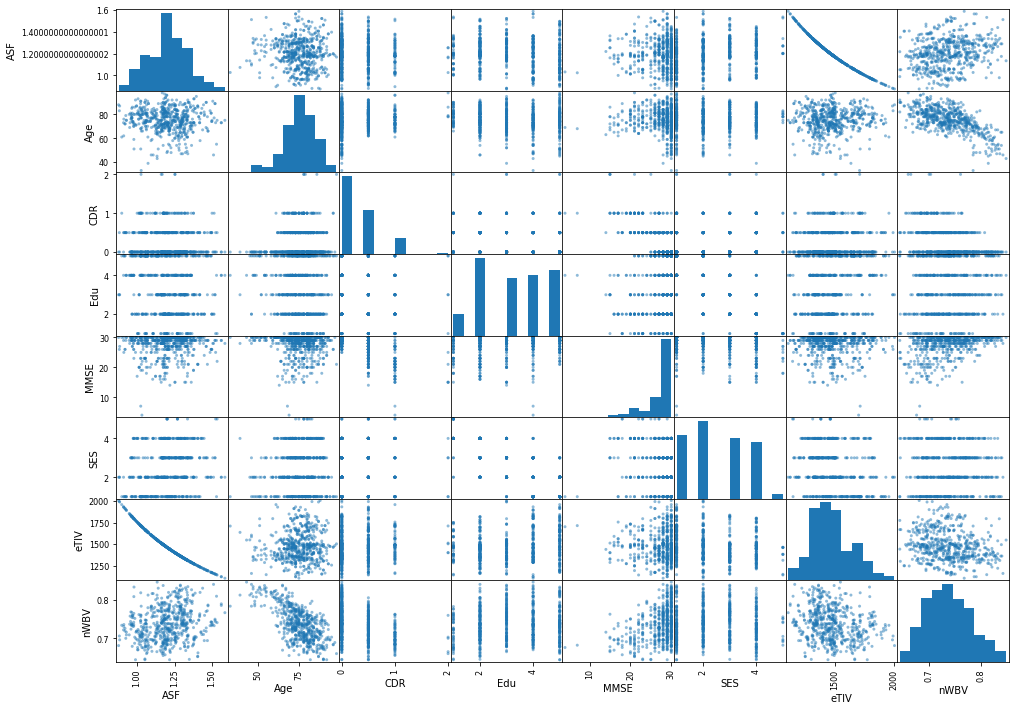

In [26]:
pd.plotting.scatter_matrix(data[numerical_columns], diagonal='hist')
plt.show()

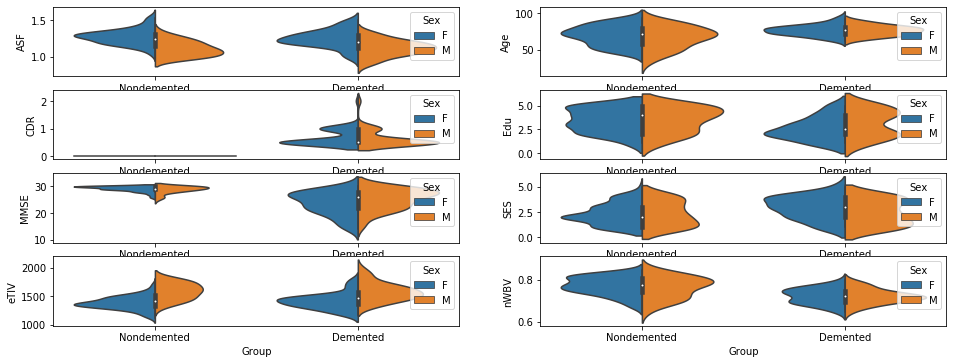

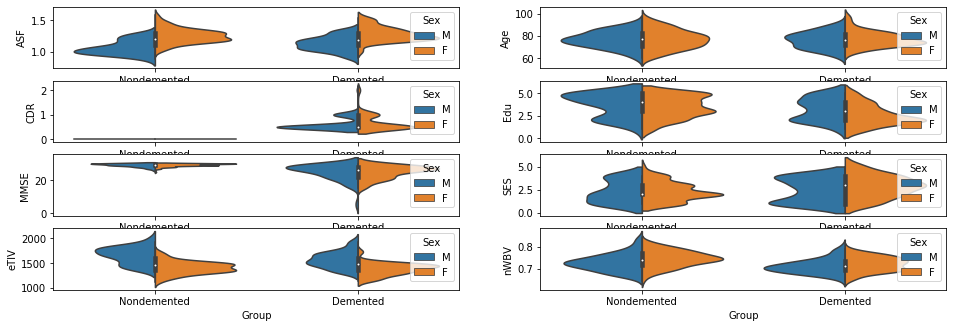

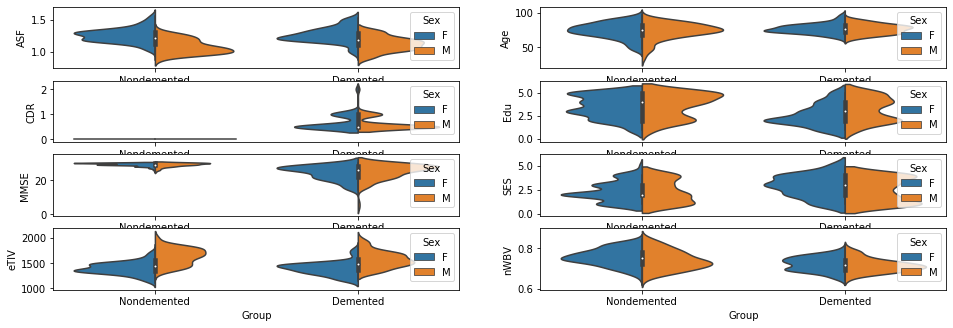

In [27]:
violinplots(cross)
violinplots(long)
violinplots(data)

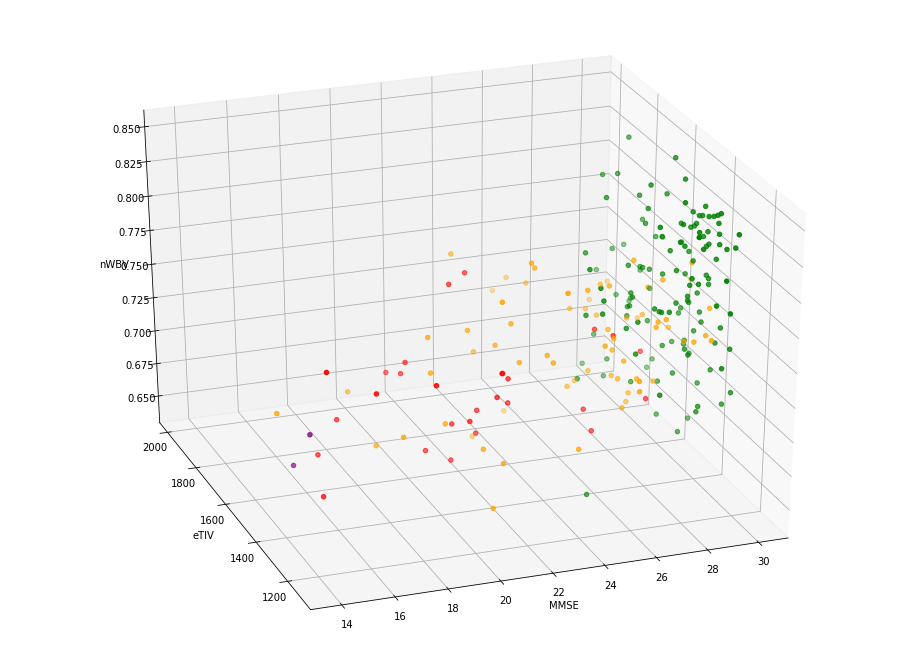

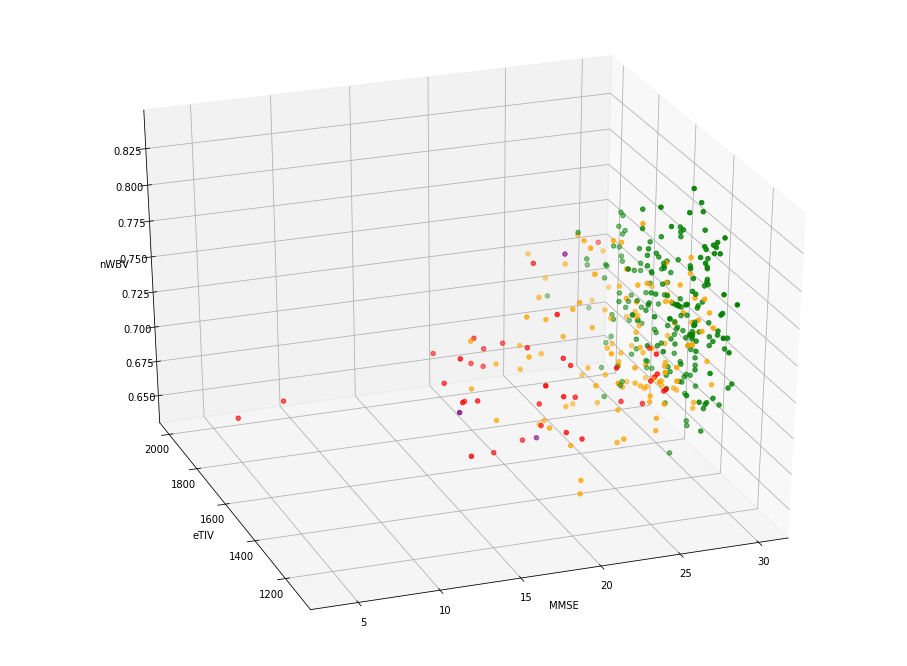

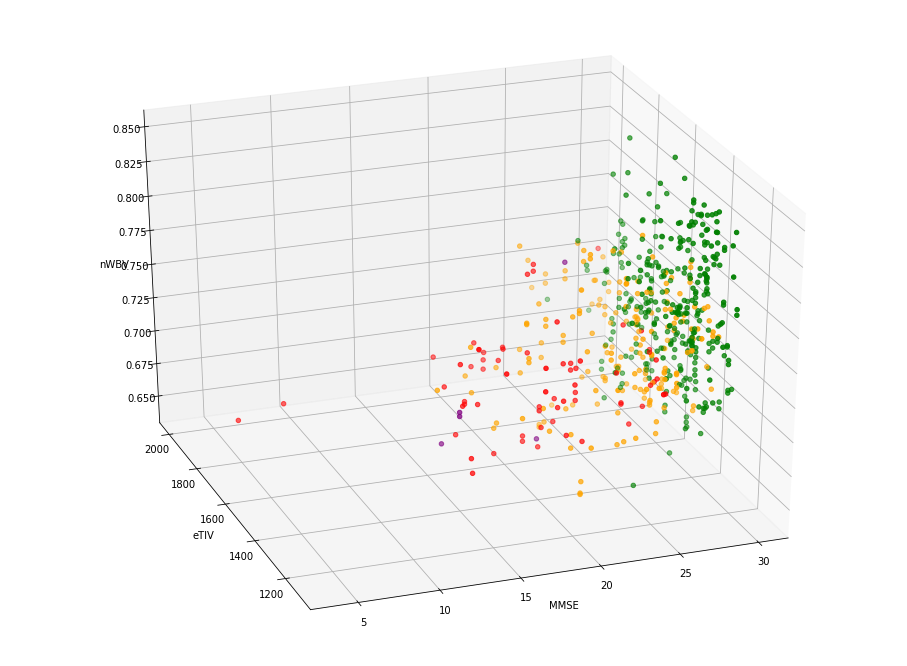

In [28]:
three_d_plot(cross)
three_d_plot(long)
three_d_plot(data)

In [29]:
stats_table = stats_table(data, numerical_columns)

In [30]:
skew_kurt_table = skew_and_kurtosis(data, numerical_columns)
skew_kurt_table

,Skew,Kurtosis
ASF,0.035466,-0.220540
Age,-0.727202,1.160860
CDR,1.334996,2.160944
Edu,-0.036131,-1.225921
MMSE,-2.061358,5.235330
SES,0.199024,-1.101424
eTIV,0.545001,-0.008311
nWBV,0.265585,-0.503772


### Machine Learning Algorithms [Rewrite this section]

<p style='text-align: justify'>Eight machine learning models were trained against six different feature groups. MMSE was the single most predictive feature: all eight models trained with only MMSE data achieved cross-validation scores greater than 80%. Adding Age, eTIV, and nWBV data improved the best mean accuracy score to 89 $\pm$ 3%. A full dataset with MMSE, Age, eTIV, nWBV, SES, Edu, and Sex did not improve the score. The adaptive boosting algorithm achieved the highest accuracy and benefitted from the most from the addition of new features. The optimized algorithm parameters used a random forest estimator classifier with 1000 estimators, 1.0 learning rate, 1 minimum leaf sample, 2 minimum leaf splits, and no maxima. The strength of adaptive boosting in correlating disparate data sources while avoiding overfitting worked well with this data set. While the combination of MMSE, Age, eTIV, and nWBV achieved the highest accuracy, Age, eTIV, and nWBV individually performed poorly, even with the adaptive boosting algorithm. Individual Age, eTIV, and nWBV features resulted adaptive boosting scores of 59 $\pm$ 6, 66 $\pm$ 4, 59 $\pm$ 3, respectively. </p>

<p style='text-align: justify'>Gaussian naive Bayes, decision tree, and random forest models did not improve as more data was provided, consistently reporting approximately 82% accuracy regardless of the addition of features to the MMSE data. Unexpectedly, nearest neighbor and multilayer perceptron classifiers became less accurate with more features. </p>

<p style='text-align: justify'></p>

In [45]:
# analysis = ml_table(df=data, features=features, targets=targets_num, models=model_list)

Now analyzing: ['Age'] ... ['Edu'] ... ['SES'] ... ['MMSE'] ... ['nWBV'] ... ['eTIV'] ... ['Age', 'Edu'] ... ['Age', 'SES'] ... ['Age', 'MMSE'] ... ['Age', 'nWBV'] ... ['Age', 'eTIV'] ... ['Edu', 'SES'] ... ['Edu', 'MMSE'] ... ['Edu', 'nWBV'] ... ['Edu', 'eTIV'] ... ['SES', 'MMSE'] ... ['SES', 'nWBV'] ... ['SES', 'eTIV'] ... ['MMSE', 'nWBV'] ... ['MMSE', 'eTIV'] ... ['nWBV', 'eTIV'] ... ['Age', 'Edu', 'SES'] ... ['Age', 'Edu', 'MMSE'] ... ['Age', 'Edu', 'nWBV'] ... ['Age', 'Edu', 'eTIV'] ... ['Age', 'SES', 'MMSE'] ... ['Age', 'SES', 'nWBV'] ... ['Age', 'SES', 'eTIV'] ... ['Age', 'MMSE', 'nWBV'] ... ['Age', 'MMSE', 'eTIV'] ... ['Age', 'nWBV', 'eTIV'] ... ['Edu', 'SES', 'MMSE'] ... ['Edu', 'SES', 'nWBV'] ... ['Edu', 'SES', 'eTIV'] ... ['Edu', 'MMSE', 'nWBV'] ... ['Edu', 'MMSE', 'eTIV'] ... ['Edu', 'nWBV', 'eTIV'] ... ['SES', 'MMSE', 'nWBV'] ... ['SES', 'MMSE', 'eTIV'] ... ['SES', 'nWBV', 'eTIV'] ... ['MMSE', 'nWBV', 'eTIV'] ... ['Age', 'Edu', 'SES', 'MMSE'] ... ['Age', 'Edu', 'SES', 'nWB

In [46]:
# analysis.to_pickle('190807.pkl')

In [3]:
# pkld_analysis = pd.read_pickle('190807.pkl')

In [4]:
# pkld_analysis_mean = pkld_analysis.xs('mean', level=1).astype('float64')

In [5]:
# pkld_analysis_mean.to_pickle('190807_mean.pkl')

In [6]:
pkld_analysis_mean = pd.read_pickle('190807_mean.pkl')

,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,MLPClassifier,SVC,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
Age,0.560861,0.568747,0.555713,0.536067,0.537720,0.578652,0.529456,0.552327
Edu,0.628145,0.628145,0.544574,0.608660,0.628145,0.628145,0.628145,0.628145
SES,0.594602,0.617409,0.603512,0.617409,0.617409,0.617409,0.617409,0.605235
MMSE,0.826731,0.826731,0.826731,0.797101,0.826731,0.826731,0.826731,0.826731
nWBV,0.665972,0.672543,0.616641,0.654456,0.657789,0.590357,0.626545,0.651164
eTIV,0.555821,0.512994,0.621681,0.560861,0.674210,0.651298,0.578853,0.563951
"Age, Edu",0.637968,0.636341,0.608323,0.608660,0.600112,0.654307,0.588489,0.608188
"Age, SES",0.606805,0.631537,0.652406,0.591261,0.669982,0.669997,0.668073,0.633261
"Age, MMSE",0.826731,0.826731,0.811882,0.729386,0.820133,0.798672,0.821759,0.828384
"Age, nWBV",0.689112,0.642711,0.646110,0.552596,0.647804,0.652775,0.690644,0.665878


In [68]:
pkld_analysis_mean

,DecisionTreeClassifier,GaussianNB,KNeighborsClassifier,MLPClassifier,SVC,AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
Age,0.560861,0.568747,0.555713,0.536067,0.537720,0.578652,0.529456,0.552327
Edu,0.628145,0.628145,0.544574,0.608660,0.628145,0.628145,0.628145,0.628145
SES,0.594602,0.617409,0.603512,0.617409,0.617409,0.617409,0.617409,0.605235
MMSE,0.826731,0.826731,0.826731,0.797101,0.826731,0.826731,0.826731,0.826731
nWBV,0.665972,0.672543,0.616641,0.654456,0.657789,0.590357,0.626545,0.651164
eTIV,0.555821,0.512994,0.621681,0.560861,0.674210,0.651298,0.578853,0.563951
"Age, Edu",0.637968,0.636341,0.608323,0.608660,0.600112,0.654307,0.588489,0.608188
"Age, SES",0.606805,0.631537,0.652406,0.591261,0.669982,0.669997,0.668073,0.633261
"Age, MMSE",0.826731,0.826731,0.811882,0.729386,0.820133,0.798672,0.821759,0.828384
"Age, nWBV",0.689112,0.642711,0.646110,0.552596,0.647804,0.652775,0.690644,0.665878


In [74]:
print('{:<30}: {:<30} ({})'.format('Model', 'Feature Inputs', 'Best Score'))

for c in pkld_analysis.columns:
    print('{:<30}: {:<30} ({:1.3f})'.format(c, pkld_analysis_mean[c].idxmax(), pkld_analysis_mean[c].max()))

Model                         : Feature Inputs                 (Best Score)
DecisionTreeClassifier        : Age, SES, MMSE                 (0.837)
GaussianNB                    : Age, SES, MMSE, eTIV           (0.835)
KNeighborsClassifier          : Age, Edu, SES, MMSE, nWBV      (0.833)
MLPClassifier                 : Edu, MMSE                      (0.825)
SVC                           : SES, MMSE, nWBV                (0.837)
AdaBoostClassifier            : Age, SES, MMSE, nWBV, eTIV     (0.891)
GradientBoostingClassifier    : Age, Edu, SES, MMSE, eTIV      (0.881)
RandomForestClassifier        : SES, MMSE, nWBV                (0.833)


### AdaBoost, GradBoost best + improved with increasing inputs

### MLP worst + worsened with increasing inputs

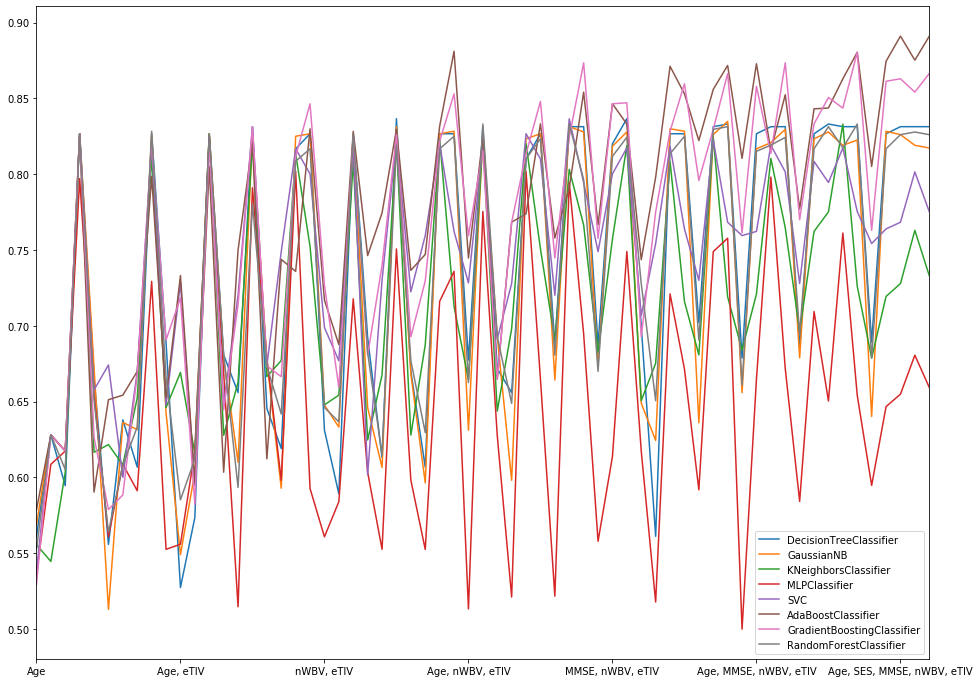

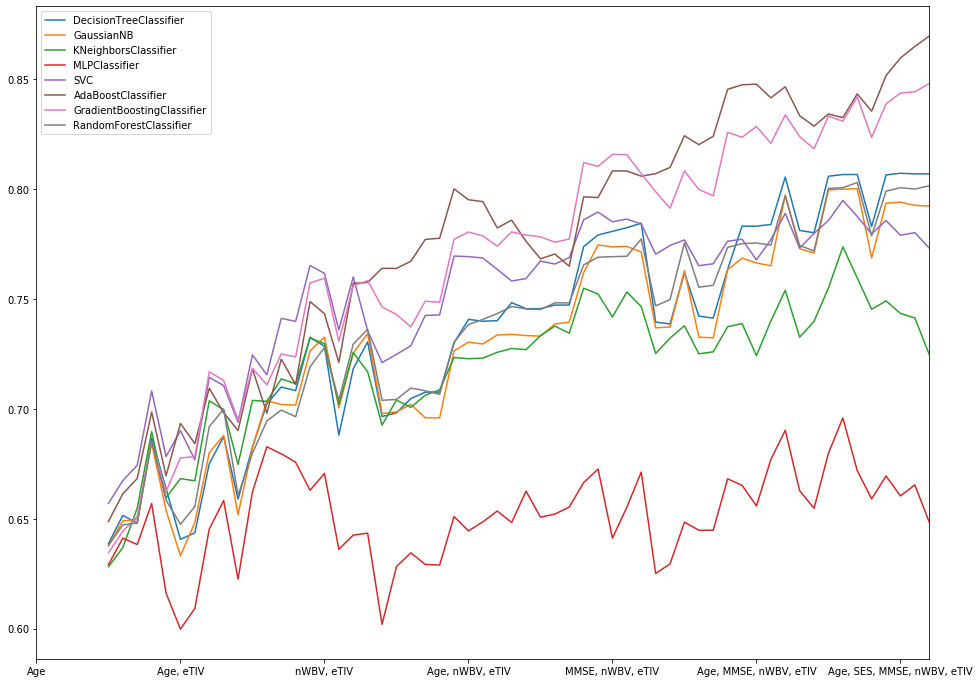

In [81]:
pkld_analysis_mean.plot()
pkld_analysis_mean.rolling(6).mean().plot()

## <a id='conclusion'>Conclusion</a>

## <a id='acknowledgements'>Acknowledgements</a>
<p style='text-align: justify'>OASIS data was generated and made available to the public through support from the following grants: P50 AG05681, P01 AG03991, R01 AG021910, P50 MH071616, U24 RR021382, R01 MH56584.</p>

## <a id='references'>References</a>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>American Psychiatric Association. 2013. Diagnostic and statistical manual of mental disorders: DSM-5. 5th Ed. Washington, DC: American Psychiatric Association. pp. 591-603. ISBN 978-0-89042-554-1.</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Budson A, Solomon P. 2011. Memory loss: A practical guide for clinicians. Elsevier Saunders. ISBN 978-1-4160-3597-9.</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Hardy J, Allsop D. 1991. Amyloid deposition as the central event in aetiology of Alzheimer's disease. Trends Pharmacol Sci 12: 383-388. [doi: 10.1016/0165-6147(91)90609-V](https://doi.org/10.1016/0165-6147(91)90609-V).</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Loy CT, Schofield PR, Turner AM, Kwok JB. 2014. Genetics of dementia. Lancet 383: 828-840. [doi: 10.1016/S0140-6736(13)60630-3](https://doi.org/10.1016/S0140-6736(13)60630-3).</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Marcus DS, Wang TH, Parker J, Csernansky JG, Morris JC, Buckner RL. 2007. Open Access Series of Imaging Studies (OASIS): Cross-sectional MRI data in young, middle aged, nondemented, and demented older adults. J Cognitive Neurosci 19: 1498-1507. [doi: 10.1162/jocn.2007.19.9.1498](https://doi.org/10.1162/jocn.2007.19.9.1498).</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Marcus DS, Fotenos AF, Csernansky JG, Morris JC, Buckner RL. 2010. Open Access Series of Imaging Studies (OASIS): Longitudinal MRI data in nondemented and demented older adults. J Cognitive Neurosci 22: 2677-2684. [doi: 10.1162/jocn.2009.21407](https://doi.org/10.1162/jocn.2009.21407)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Mielke MM. 2018. Sex and gender differences in Alzheimer Disease dementia. Psychiatric Times 35. [Link](https://www.psychiatrictimes.com/special-reports/sex-and-gender-differences-alzheimer-disease-dementia).
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Pangman VC, Sloan J, Guse L. 2000. An examination of psychometric properties of the Mini-Mental State Examination and the Standardized Mini-Mental State Examination: Implications for clinical practice. Appl Nurs Res 13: 209-213. [doi: 10.1053/apnr.2000.9231](https://doi.org/10.1053/apnr.2000.9231).</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Tuijl JP, Scholte EM, deCraen AJM, van der Mast RC. 2012. Screening for cognitive impairment in older general hospital patients: Comparison of the six-item cognitive test with the Mini-Mental State Examination. Int J Geriatr Psych 27: 755-762. [doi: 10.1002/gps.2776](https://doi.org/10.1002/gps.2776).</p>

##### TO BE CITED

<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Prince M, Bryce R, Albanese E, Wimo A, Ribeiro W, Ferri CP. 2013. The global prevalence of dementia: A systematic review and metaanalysis. Alzheimers Dement 9: 63-75. [doi: 10.1016/j.alz.2012.11.007](https://doi.org/10.1016/j.alz.2012.11.007)</p>
    * general review
    * dementia = neurodegeneration, loss of cognitive ability and memory
    * commonly Alzheimer's
    * vascular dementia = from stroke
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Sousa RM, Ferri CP, Acosta D, Albanese E, Guerra M, Huang Y, Jacob KS, Jotheswaran AT, Rodriguez JJ, Pichardo GR, Rodriguez MC, Salas A, Sosa AL, Williams J, Zuniga T, Prince M. 2009. Contribution of chronic diseases to disability in elderly people in countries with low and middle incomes: A 10/66 Dementia Research Group population-based survey. Lancet 374: 1821-1830. [doi: 10.1016/S0140-6736(09)61829-8](https://doi.org/10.1016/S0140-6736(09)61829-8)</p>
    * dementia vastly more common in elderly (senility)
    * dementia more common in low to middle-income nations
    
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Burns A. 2009. Dementia. BMJ 338: b75. [doi: 10.1136/bmj.b75](https://doi.org/10.1136/bmj.b75)</p>
    * Alzheimer's majority of dementia
    

    * MMSE is 30-pt questionnaire to measure cognitive impairment
    * attention, calculation, recall, language, orientation, follow commands
    * sensitive to age, education
    * insensitive to mild impairment
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Tombaugh TN, McIntyre NJ. 1992. The Mini-Mental State Examination: A comprehensive review. J Am Geriatr Soc 40: 922-935. [doi: 10.1111/j.1532-5415.1992.tb01992.x](https://doi.org/10.1111/j.1532-5415.1992.tb01992.x)</p>
    * MMSE is valid for moderate-to-severe cognitive impairment
    * Affected by age, education, cultural background
    * Not affected by sex
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Rubin EH, Storandt M, Miller JP, Kinscherf DA, Grant EA, Morris JC, Berg L. 1998. A prospective study of cognitive function and onset of dementia in cognitively healthy elders. Arch Neurol 55: 395-401. [doi: 10.1001/archneur.55.3.395](https://doi.org/10.1001/archneur.55.3.395)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Morris JC. 1993. The Clinical Dementia Rating (CDR): Current version and scoring rules. Neurology 43: 2412b-2414b. [doi: 10.12.12/WNL.43.11.2412-a](https://doi.org/10.1212/WNL.43.11.2412-a)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Buckner RL, Head D, Parker J, Fotenos AF, Marcus D, Morris JC, Snyder AZ. 2004. A unified approach for morphometric and functional data analysis in young, old, and demented adults using automated atlas-based head size normalization: Reliability and validation against manual measurement of total intracranial volume. Neuroimage 23: 724-738. [doi: 10.1016/j.neuroimage.2004.06.018](https://doi.org/10.1016/j.neuroimage.2004.06.018)</p>
<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Fotenos AF, Snyder AZ, Girton LE, Morris JC, Buckner RL. 2005. Normative estimates of cross-sectional and longitudinal brain volume decline in aging and AD. Neurology 64: 1032-1039. [doi: 10.1212/01.WNL.0000154530.72969.11](https://doi.org/10.1212/01.WNL.0000154530.72969.11)</p>

<p style='text-align: justify; margin-left: 20px; text-indent: -20px'>Pendregosa F, Varoquaux G, Gramfort A, Michel V, Thirion B, Grisel O, Blondel M, Prettenhofer P, Weiss R, Dubourg V, Vanderplas J, Passos A, Cournapeau D, Brucher M, Perrot M, Duchesnay E. 2011. Scikit-Learn: Machine learning in Python. J Mach Learn Res 12: 2825-2830.</p>

# ---KERAS WIP BELOW HERE---

### Helper Functions

In [ ]:
def plot_probabilities(n, predictions, actuals):
    """
    Receives an integer, array of predicted values, array of actual values
    Plots neural network probability predictions for one-hot target classifications
    """
    prediction, actual = predictions[n], actuals[n]
    
    plt.grid(False)
    plt.yticks([0, 0.25, 0.5, 0.75, 1])
    plt.ylim([0, 1])
    
    thisplot = plt.bar([0, 1], prediction, color='gray', tick_label=['Nondemented', 'Demented'])
    prediction_single = np.argmax(prediction)
    actual_single = np.argmax(actual)
    plt.xlabel('#{}: Pred {}, Actual {}'.format(n, prediction_single, actual_single))
    
    if prediction_single == actual_single:
        thisplot[prediction_single].set_color('g')
    else:
        thisplot[prediction_single].set_color('r')

### Tensorflow

In [ ]:
def keras_model(x, y, x_val=None, y_val=None, num_steps=200, batch=32, neurons=(64,), num_classes=2, dropout_rate=0.25, 
                optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
    model = Sequential()
    for n in neurons:
        model.add(layers.Dense(n, activation=tf.nn.relu, input_shape=(x.shape[1], 1)))
        model.add(layers.Dropout(dropout_rate))
    model.add(layers.Flatten())
    model.add(layers.Dense(num_classes, activation=tf.nn.softmax))
    
    model.build()
    print('Summary', model.summary())
    
    early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=50) 
    
    fit = model.fit(x, y, 
                        epochs=num_steps, 
                        batch_size=batch, 
                        validation_data=(x_val, y_val), 
                        callbacks=[early_stop], 
                        verbose=1)
    
    return model, fit

In [ ]:
# x_input, y_input = make_features_targets(data, )

# model, history = keras_model()

# train_accuracy = history.history['acc']
# test_accuracy = history.history['val_acc']

# plt.plot(history.epoch, train_accuracy, label='Train Accuracy')
# plt.plot(history.epoch, test_accuracy, label='Test Accuracy')
# plt.legend(loc='best')
# plt.show()

In [ ]:
# pred = model.predict(combined_test_features_nn)

In [ ]:
# for n in range(16):
#     random_number = randint(0, combined_test_features.shape[0]-1)
#     plt.subplot(4, 4, n+1)
#     plot_probabilities(random_number, pred_tf, combined_test_targets_nn)
# plt.tight_layout()
# plt.show()